In [33]:
# Imports
import json, re, numpy as np, numpy.linalg as nplin, matplotlib.pyplot as plt, matplotlib.mlab as mlab, string, base64, os
from __future__ import division
from io import BytesIO
from pydub import AudioSegment
from scipy.ndimage.filters import maximum_filter
%matplotlib inline

# Am I working on AWS?
AWS = False

In [3]:
!wget http://s3.amazonaws.com/stat-37601/new-songs.mp3.base64.json
!mv new-songs.mp3.base64.json data/

--2015-05-10 21:59:45--  http://s3.amazonaws.com/stat-37601/new-songs.mp3.base64.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.17.232
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.17.232|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 359122957 (342M) [application/json]
Saving to: ‘new-songs.mp3.base64.json’

100%[======================================>] 359,122,957 3.47MB/s   in 1m 42s 

2015-05-10 22:01:26 (3.37 MB/s) - ‘new-songs.mp3.base64.json’ saved [359122957/359122957]



In [48]:
# Load Data
if AWS == True:
    songsFile = "s3n://stat-37601/new-songs.mp3.base64.json"
else:
    songsFile = "data/new-songs.mp3.base64.json"

snipets = sc.textFile(songsFile, 100).map(json.loads).cache()
snipets.count()

5627

In [53]:
# Grab a test subset of data
snipets3 = snipets.filter(lambda x: int(x["song_id"]) <= 3)
snipets3.count()

278

#### (a) process songs

In [40]:
# Helper functions, largely assembled from code given by homework/TA

def to_pydub(data):
    return AudioSegment.from_mp3(BytesIO(base64.b64decode(data)))

def audio_segment_to_samples(data):
    """Converts wav into a numpy array"""
    audio = to_pydub(data)
    wave = audio.export('_', format='wav')
    wave.seek(0)
    return np.frombuffer(wave.read(), np.int16)[24:] / 2.**15

def audio_segment_in_ipython(song_data):
    """Plays a wav file in python"""
    from IPython.core.display import HTML, display
    display(HTML("""<audio controls="controls" style="width:600px" >
        <source controls
            src="data:audio/mp3;base64,{}" type="audio/mp3" />
      </audio>""".format(song_data)))
    
def find_peaks(samples):
    """Finds peaks in sound file that are at least 20 units away from each other and greater than -150 db"""
    ft_graph = mlab.specgram(samples, scale_by_freq=False)[0]
    # Don’t rescale by 1/f!
    maxes = (maximum_filter(ft_graph, size=20) == ft_graph) & (ft_graph > -150)
    # Compute relative maxima 20 units away from others, where
    # intensity is greater than -150 dB.
    freqs, times = np.where(maxes)audio_segment_to_samples
    return (freqs, times)

def play_pydub(pyaudio):
    """Plays a pydub audio segment in ipython"""
    pyaudio.export('tmp.mp3', format='mp3')
    audio_segment_in_ipython(base64.b64encode(open("tmp.mp3").read()))
    os.remove('tmp.mp3')

def assemble_songs(rdd):
    """
    Takes snippets of songs in an rdd and assembles them back into one whole piece.
    
    There will be noticable loss from being converted back and forth into mp3
    """
    output = rdd.map(lambda songDict: (songDict['song_id'],(songDict['time_offset'],to_py_audio(songDict['data']))))\
        .groupByKey()\
        .map(lambda (id,audio_tuples): (id, [audio for time_offset,audio in sorted(audio_tuples)]))\
        .map(lambda (id,audio_list)  : (id, reduce(lambda x,y: x+y, audio_list)))
    return output

In [75]:
# Process song into "fingerprint" of peaks - gives arrays of peak times and frequencies
snipets_fp = snipets.map(lambda songDict: (songDict['song_id'],songDict['time_offset'],find_peaks(audio_segment_to_samples(songDict['data'])))).cache()

In [77]:
# Calculate number of peaks by song
songs_peaks = snipets_fp.map(lambda (sid,off,(freqs,times)): (sid,len(freqs)))\
    .reduceByKey(lambda x,y: x+y)\
    .collect()

On average, there are 166221.47 peaks per song.


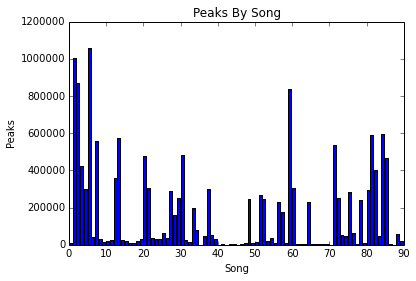

In [83]:
# summarize
song_ids, freqs = zip(*songs_peaks)    
    
print "On average, there are %.2f peaks per song." % np.mean(freqs)

plt.bar(song_ids,freqs)
plt.title("Peaks By Song")
plt.xlabel('Song')
plt.ylabel('Peaks')
plt.show()

#### (b) Hashing